# 1.2 Ubiquitous Ambiguity
- Notice that there's no ambiguity concerning the meaning of any of the words; e.g. the word shot doesn't refer to the act of using a gun in the first sentence, and using a camera in the second sentence.

In [1]:
import nltk

groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")

sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
trees = []
parser = nltk.ChartParser(groucho_grammar)
for tree in parser.parse(sent):
    trees.append(tree)

trees

[Tree('S', [Tree('NP', ['I']), Tree('VP', [Tree('VP', [Tree('V', ['shot']), Tree('NP', [Tree('Det', ['an']), Tree('N', ['elephant'])])]), Tree('PP', [Tree('P', ['in']), Tree('NP', [Tree('Det', ['my']), Tree('N', ['pajamas'])])])])]),
 Tree('S', [Tree('NP', ['I']), Tree('VP', [Tree('V', ['shot']), Tree('NP', [Tree('Det', ['an']), Tree('N', ['elephant']), Tree('PP', [Tree('P', ['in']), Tree('NP', [Tree('Det', ['my']), Tree('N', ['pajamas'])])])])])])]

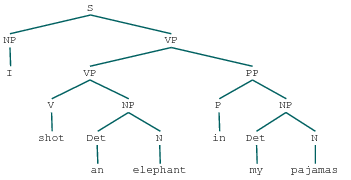

In [2]:
trees[0]

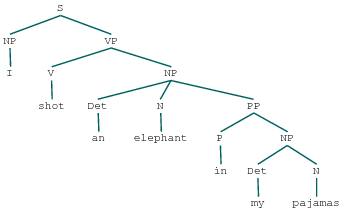

In [3]:
trees[1]

# 3.1 A Simple Grammar

In [4]:
grammar1 = nltk.CFG.fromstring("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)

In [5]:
sent = "Mary saw Bob".split()
trees = []
rd_parser = nltk.RecursiveDescentParser(grammar1)

for tree in rd_parser.parse(sent):
     trees.append(tree)

trees

[Tree('S', [Tree('NP', ['Mary']), Tree('VP', [Tree('V', ['saw']), Tree('NP', ['Bob'])])])]

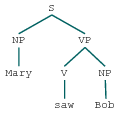

In [6]:
trees[0]

In [7]:
grammar2 = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> Det Nom | PropN
  Nom -> Adj Nom | N
  VP -> V Adj | V NP | V S | V NP PP
  PP -> P NP
  PropN -> 'Buster' | 'Chatterer' | 'Joe'
  Det -> 'the' | 'a'
  N -> 'bear' | 'squirrel' | 'tree' | 'fish' | 'log'
  Adj  -> 'angry' | 'frightened' |  'little' | 'tall'
  V ->  'chased'  | 'saw' | 'said' | 'thought' | 'was' | 'put'
  P -> 'on'
  """)

grammar2

<Grammar with 31 productions>

# 4.1 Recursive Descent Parsing
- Break a high-level goal into several lower-level subgoals

![Image](images/rdparser1-6.png)

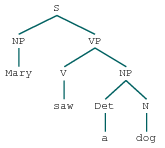

In [8]:
rd_parser = nltk.RecursiveDescentParser(grammar1)
sent = 'Mary saw a dog'.split()
trees = []
for tree in rd_parser.parse(sent):
    trees.append(tree)
    
trees[0]

# 4.2 Shift-Reduce Parsing
- Bottom-up parser is the shift-reduce parser

![Image](images/srparser1-6.png)

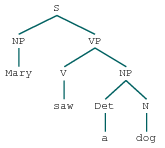

In [9]:
sr_parser = nltk.ShiftReduceParser(grammar1)
sent = 'Mary saw a dog'.split()
trees = []
for tree in sr_parser.parse(sent):
    trees.append(tree)
    
trees[0]

# 4.4 Well-Formed Substring Tables
- This approach to parsing is known as chart parsing

In [10]:
text = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
groucho_grammar.productions(rhs=text[1])

[V -> 'shot']

In [11]:
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    wfst = [[None for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        wfst[i][i+1] = productions[0].lhs()
    return wfst

def complete_wfst(wfst, tokens, grammar, trace=False):
    index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                if nt1 and nt2 and (nt1,nt2) in index:
                    wfst[start][end] = index[(nt1,nt2)]
                    if trace:
                        print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                        (start, nt1, mid, nt2, end, start, index[(nt1,nt2)], end))
    return wfst

def display(wfst, tokens):
    print('\nWFST ' + ' '.join(("%-4d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-4s" % (wfst[i][j] or '.'), end=" ")
        print()
        
tokens = "I shot an elephant in my pajamas".split()
wfst0 = init_wfst(tokens, groucho_grammar)
display(wfst0, tokens)


wfst1 = complete_wfst(wfst0, tokens, groucho_grammar)
display(wfst1, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    .    .    .    .    
1    .    V    .    .    .    .    .    
2    .    .    Det  .    .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    .    
5    .    .    .    .    .    Det  .    
6    .    .    .    .    .    .    N    

WFST 1    2    3    4    5    6    7   
0    NP   .    .    S    .    .    S    
1    .    V    .    VP   .    .    VP   
2    .    .    Det  NP   .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    PP   
5    .    .    .    .    .    Det  NP   
6    .    .    .    .    .    .    N    


In [12]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar, trace=True)

[2] Det [3]   N [4] ==> [2]  NP [4]
[5] Det [6]   N [7] ==> [5]  NP [7]
[1]   V [2]  NP [4] ==> [1]  VP [4]
[4]   P [5]  NP [7] ==> [4]  PP [7]
[0]  NP [1]  VP [4] ==> [0]   S [4]
[1]  VP [4]  PP [7] ==> [1]  VP [7]
[0]  NP [1]  VP [7] ==> [0]   S [7]


# 5 Dependencies and Dependency Grammar
- Dependency is a binary asymmetric relation that holds between a head and its dependents. 
- The head of a sentence is usually taken to be the tensed verb, and every other word is either dependent on the sentence head, or connects to it through a path of dependencies.

![Image](images/depgraph0.png)
- I is the SBJ (subject) of shot (which is the head of the whole sentence), and in is an NMOD (noun modifier of elephant). 
- In contrast to phrase structure grammar, therefore, dependency grammars can be used to directly express grammatical functions as a type of dependency.

In [13]:
groucho_dep_grammar = nltk.DependencyGrammar.fromstring("""
'shot' -> 'I' | 'elephant' | 'in'
'elephant' -> 'an' | 'in'
'in' -> 'pajamas'
'pajamas' -> 'my'
""")

# only captures bare dependency information without specifying the type of dependency
print(groucho_dep_grammar)

Dependency grammar with 7 productions
  'shot' -> 'I'
  'shot' -> 'elephant'
  'shot' -> 'in'
  'elephant' -> 'an'
  'elephant' -> 'in'
  'in' -> 'pajamas'
  'pajamas' -> 'my'


In [14]:
# capturing the attachment ambiguity
pdp = nltk.ProjectiveDependencyParser(groucho_dep_grammar)
sent = 'I shot an elephant in my pajamas'.split()
trees = []
for tree in pdp.parse(sent):
    trees.append(tree)

trees

[Tree('shot', ['I', Tree('elephant', ['an', Tree('in', [Tree('pajamas', ['my'])])])]),
 Tree('shot', ['I', Tree('elephant', ['an']), Tree('in', [Tree('pajamas', ['my'])])])]

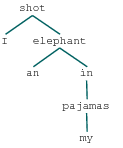

In [15]:
trees[0]

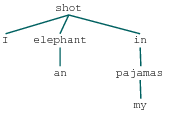

In [16]:
trees[1]

# 6.1 Treebanks and Grammars

In [17]:
from nltk.corpus import treebank
t = treebank.parsed_sents('wsj_0001.mrg')[0]
print(t)

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


1111


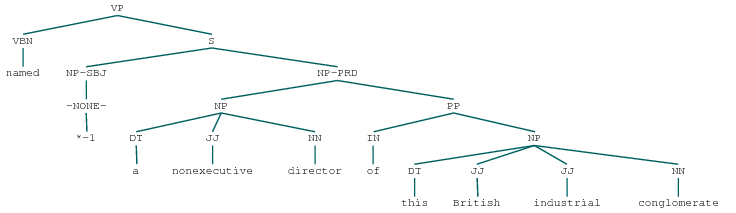

In [18]:
def filter(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'VP') and ('S' in child_nodes)

from nltk.corpus import treebank
trees = [subtree for tree in treebank.parsed_sents()
         for subtree in tree.subtrees(filter)]

print(len(trees))
trees[0]

In [19]:
"""
It finds pairs of prepositional phrases where the preposition and noun are fixed, 
but where the choice of verb determines whether the prepositional phrase is attached to the VP or to the NP.
"""
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)

for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:', sorted(table[key]['N']), 'V:', sorted(table[key]['V']))

%-below-level N: ['left'] V: ['be']
%-from-year N: ['was'] V: ['declined', 'dropped', 'fell', 'grew', 'increased', 'plunged', 'rose', 'was']
%-in-August N: ['was'] V: ['climbed', 'fell', 'leaping', 'rising', 'rose']
%-in-September N: ['increased'] V: ['climbed', 'declined', 'dropped', 'edged', 'fell', 'grew', 'plunged', 'rose', 'slipped']
%-in-week N: ['declined'] V: ['was']
%-to-% N: ['add', 'added', 'backed', 'be', 'cut', 'go', 'grow', 'increased', 'increasing', 'is', 'offer', 'plummet', 'reduce', 'rejected', 'rise', 'risen', 'shaved', 'wants', 'yield', 'zapping'] V: ['fell', 'rise', 'slipped']
%-to-million N: ['declining'] V: ['advanced', 'climbed', 'cutting', 'declined', 'declining', 'dived', 'dropped', 'edged', 'fell', 'gained', 'grew', 'increased', 'jump', 'jumped', 'plunged', 'rising', 'rose', 'slid', 'slipped', 'soared', 'tumbled']
1-to-21 N: ['dropped'] V: ['dropped']
1-to-33 N: ['gained'] V: ['dropped', 'fell', 'jumped']
1-to-4 N: ['added'] V: ['gained']
1-to-47 N: ['jumped']

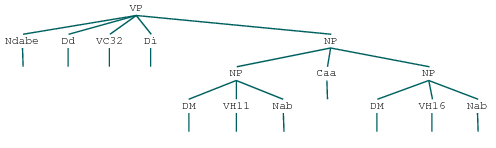

In [20]:
nltk.corpus.sinica_treebank.parsed_sents()[3450]

# 7 Summary
- Sentences have internal organization that can be represented using a tree. Notable features of constituent structure are: recursion, heads, complements and modifiers.
- A grammar is a compact characterization of a potentially infinite set of sentences; we say that a tree is well-formed according to a grammar, or that a grammar licenses a tree.
- A grammar is a formal model for describing whether a given phrase can be assigned a particular constituent or dependency structure.
- Given a set of syntactic categories, a context-free grammar uses a set of productions to say how a phrase of some category A can be analyzed into a sequence of smaller parts α1 ... αn.
- A dependency grammar uses productions to specify what the dependents are of a given lexical head.
- Syntactic ambiguity arises when one sentence has more than one syntactic analysis (e.g. prepositional phrase attachment ambiguity).
- A parser is a procedure for finding one or more trees corresponding to a grammatically well-formed sentence.
- A simple top-down parser is the recursive descent parser, which recursively expands the start symbol (usually S) with the help of the grammar productions, and tries to match the input sentence. This parser cannot handle left-recursive productions (e.g., productions such as NP -> NP PP). It is inefficient in the way it blindly expands categories without checking whether they are compatible with the input string, and in repeatedly expanding the same non-terminals and discarding the results.
- A simple bottom-up parser is the shift-reduce parser, which shifts input onto a stack and tries to match the items at the top of the stack with the right hand side of grammar productions. This parser is not guaranteed to find a valid parse for the input even if one exists, and builds substructure without checking whether it is globally consistent with the grammar.